# Introduction

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx 
np.set_printoptions(suppress=True)      # to avoid scientific notation

### Data preparation

In [2]:
# cac40.csv contains adjusted close prices from 2023 April to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
cac40 = cac40.loc['2024-01-01':]
cac40_evolution = cac40['^FCHI']/cac40['^FCHI'].iloc[0]

returns = cac40.drop(columns=['^FCHI']).pct_change().dropna()
tickers = returns.columns
T,N = returns.shape

# Optimisation Problem

## Weights initialisation

In [3]:
def init_weights(returns_df,T_w=252,w_max=0.2,var_max = 5e-4 ):
    # Initialisation: window length = T
    returns_init = returns_df.iloc[:T_w].to_numpy()
    w = cvx.Variable(N)

    # Expected log-growth
    g = cvx.mean( cvx.log( 1 + returns_init@w ) , axis=0)

    # Volatility as variance 
    variance = cvx.var(returns_init@w)

    # Problem formulation
    objective = cvx.Maximize(g)
    constraints = [w>=0,w<=w_max, cvx.sum(w)==1,variance<=var_max]
    kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
    kelly_opt.solve()

    return np.round(w.value,4)


# Test
T_w_init = 252
w_0 = init_weights(returns,T_w =T_w_init )

# Display
weights = pd.DataFrame(w_0,index=tickers,columns=['Init weights'])
weights[weights!=0].dropna()

,Init weights
AC.PA,0.2000
EL.PA,0.2000
RNO.PA,0.1697
SAF.PA,0.0882
SGO.PA,0.1421
SU.PA,0.2000


Portfolio Raw Retrun: 1.361


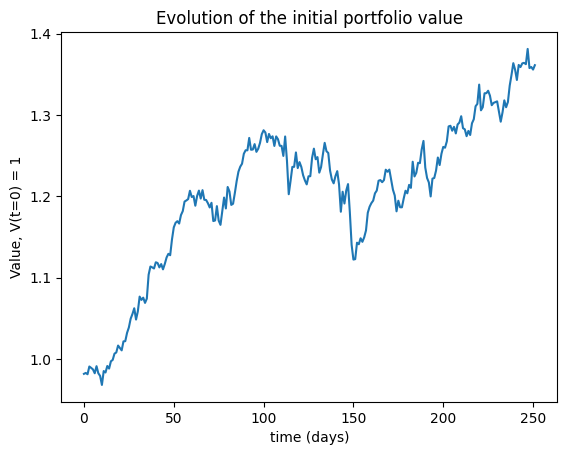

In [4]:
# Overlook of initial portfolio
portfolio_value = cvx.cumprod(1 + returns.iloc[:T_w_init]@w_0 )
print(f'Portfolio Raw Retrun: {portfolio_value.value[-1]:.3f}')
plt.plot(portfolio_value.value)
plt.title("Evolution of the initial portfolio value")
plt.xlabel('time (days)')
plt.ylabel('Value, V(t=0) = 1')
plt.show()

## Dynamic re-allocation

In [5]:
def realocation(returns_df, T_w=252, dt=1, w_max = 0.2, var_max = 5e-4,turnover =0.03):
    T_max,N = returns_df.shape

    # Feasability check
    if T_w>T_max:
        print('Time window too long compare to the given data:')
        print('Window length:',T_w)
        print('Data length: ', T_max)
        return

    # Weights storage
    w_0 = init_weights(returns_df,T_w=T_w,w_max=w_max,var_max=var_max)
    weights_evol = [w_0]

    # Value storage
    V = [1]

    t = T_w
    w = cvx.Variable(N)
    while t+dt<T_max:

        # Update portfolio value during the time step dt where the weights are fixed
        for k in range(t,t+dt):
            weights_evol.append(w_0)

            r = returns_df.iloc[k]@w_0
            V.append(V[-1]*(1+r))

        # Go forward by one time step
        t = t+dt        

        # Set new window of the past Tw days
        portfolio_returns_w = returns_df.iloc[t-T_w:t].to_numpy() @ w

        # Expected log-growth
        g = cvx.mean( cvx.log( 1 + portfolio_returns_w ) , axis=0)

        # Volatility as variance 
        variance = cvx.var(portfolio_returns_w)

        # Problem formulation
        objective = cvx.Maximize(g)
        constraints = [w>=0, cvx.sum(w)==1,w<=w_max,variance<= var_max, cvx.norm1(w-w_0)<=turnover]
        kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
        kelly_opt.solve()

        # Update weights
        w_0 = np.round(w.value,4)
            
    # Uptade weight and portfolio value for the remaining time
    for k in range(t,T_max):
        weights_evol.append(w_0)

        r = returns_df.iloc[k]@w_0
        V.append(V[-1]*(1+r))

    return np.array(weights_evol),np.array(V)


weights_evol,V = realocation(returns)      

c:\Users\verne\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


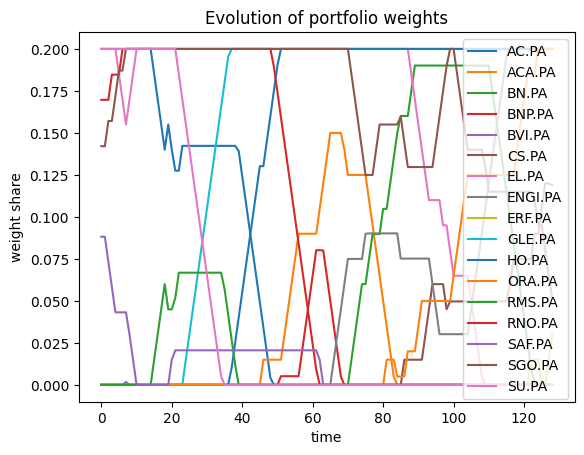

In [6]:
# Display weights
weights_evol = pd.DataFrame(np.array(weights_evol),columns=tickers)
weights_evol.loc[:, (weights_evol != 0).any(axis=0)].plot()
plt.title('Evolution of portfolio weights')
plt.xlabel('time')
plt.ylabel('weight share')
plt.show()

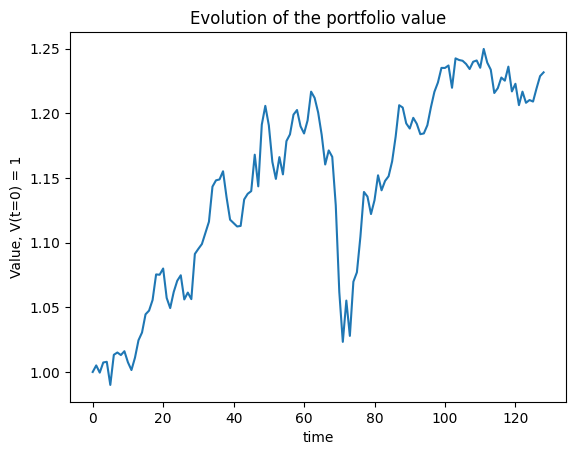

In [7]:
# Portfolio evolution
plt.plot(np.arange(129),V)
plt.title('Evolution of the portfolio value')
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.show()

# Results analysis

## Influence of the time window

c:\Users\verne\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


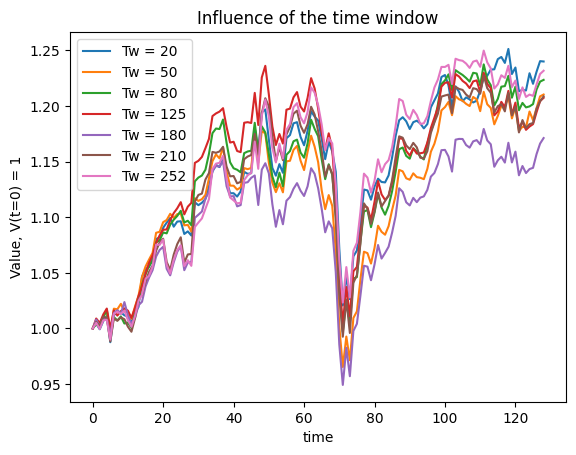

In [8]:
time_windows = [20,50,80,125,180,210,252]
time = np.arange(129)
for Tw in time_windows:
    try:
        returns_w = returns.iloc[-(128+Tw):]
        _,V = realocation(returns_w, T_w=Tw) 
        plt.plot(time,V[-129:],label=f'Tw = {Tw}')
    except TypeError:
        print('No solution for time window:', Tw)

plt.legend()
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.title('Influence of the time window')
plt.show()

## Influence of the time step

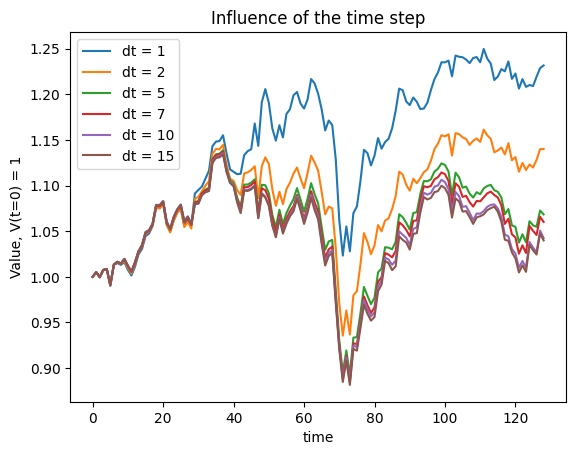

In [9]:
time_steps = [1,2,5,7,10,15]
time = np.arange(129)
for dt in time_steps:
    try:
        _,V = realocation(returns,dt=dt) 
        plt.plot(time,V,label=f'dt = {dt}')
    except TypeError:
        print('No solution for time step:', dt)

plt.legend()
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.title('Influence of the time step')
plt.show()

## Influence of the holding constraint

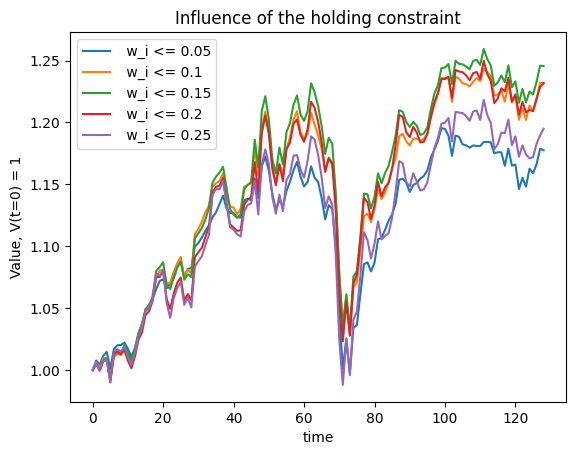

In [10]:
holding_constraints = [0.05,0.1,0.15,0.20,0.25]
for M in holding_constraints:
    try:
        _,V = realocation(returns,w_max=M) 
        plt.plot(time,V,label=f' w_i <= {M}')
    except TypeError:
        print('No solution for holding constraint:', M)

plt.legend()
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.title('Influence of the holding constraint')
plt.show()

## Influence of the variance limit

No solution for variance limit:0.00005
No solution for variance limit:0.00010


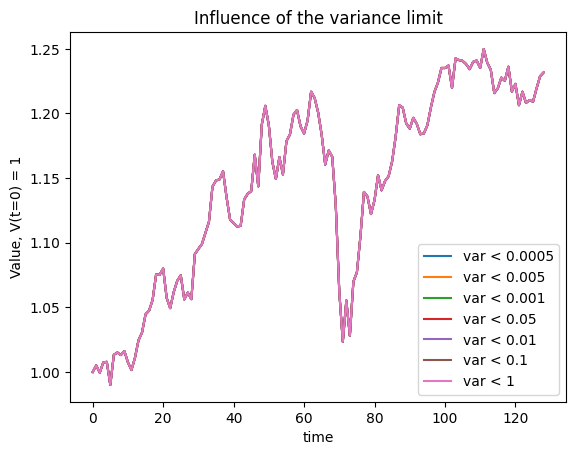

In [11]:
variance_limits = [5e-5,1e-4,5e-4,5e-3,1e-3,5e-2,0.01,0.1,1]
for s in variance_limits:
    try:
        _,V = realocation(returns,var_max=s) 
        plt.plot(time,V,label=f'var < {s}')
    except TypeError:
        print(f'No solution for variance limit:{s:.5f}')

plt.legend()
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.title('Influence of the variance limit')
plt.show()

## Influence of the turnover constraint

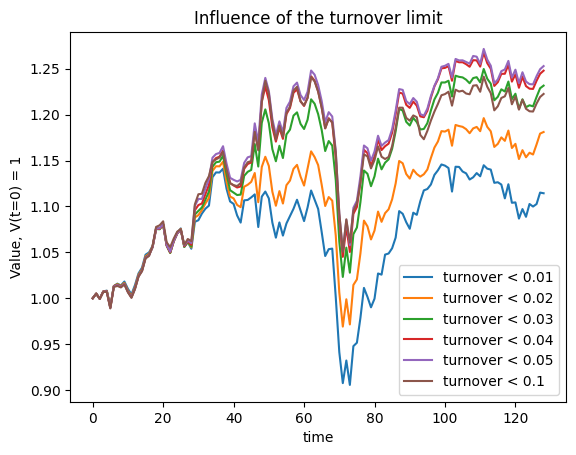

In [12]:
turnovers = [0.01,0.02,0.03,0.04,0.05,0.1]
for t in turnovers:
    try:
        _,V = realocation(returns,turnover=t) 
        plt.plot(time,V,label=f'turnover < {t}')
    except TypeError:
        print('No solution for turnover limit:', t)

plt.legend()
plt.xlabel('time')
plt.ylabel('Value, V(t=0) = 1')
plt.title('Influence of the turnover limit')
plt.show()

# Finding the best parameters

In [13]:
w1,V1 = realocation(returns,T_w=252,dt=1,w_max=0.15,turnover=0.05)
w2,V2 = realocation(returns.iloc[-148:],T_w=20,dt=1,w_max=0.15,turnover=0.05)
w3,V3 = realocation(returns,T_w=252,dt=1,w_max=0.15,turnover=0.04)
w4,V4 = realocation(returns.iloc[-148:],T_w=20,dt=1,w_max=0.15,turnover=0.04)
w5,V5 = realocation(returns,T_w=252,dt=1,w_max=0.15,turnover=0.03)
w6,V6 = realocation(returns.iloc[-148:],T_w=20,dt=1,w_max=0.15,turnover=0.03)

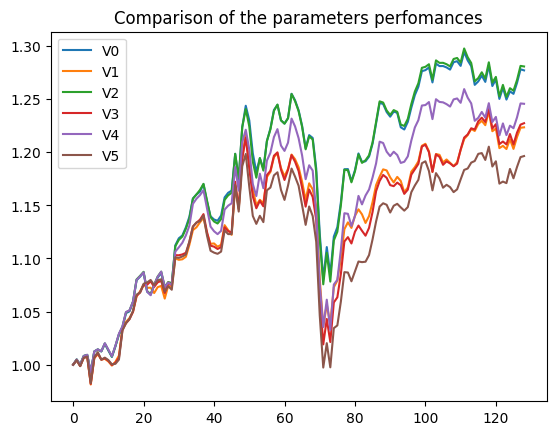

,return,std,SR,MDD
1,0.654,0.209,3.012,0.139
2,0.520,0.209,2.379,0.150
3,0.665,0.213,3.007,0.143
4,0.533,0.218,2.336,0.160
5,0.579,0.221,2.514,0.161
6,0.459,0.221,1.967,0.168


In [14]:
evolutions = [V1,V2,V3,V4,V5,V6]
comparison = pd.DataFrame(columns=['return','std','SR','MDD'])
r_f = 0.024

for k,v in enumerate(evolutions) : 
    r =  (v[1:]-v[:-1])/v[:-1]
    mu =(1+np.mean(r))**252 - 1
    std = np.sqrt(252)*np.std(r)
    sr = (mu - r_f)/std
    mdd =  np.max((np.maximum.accumulate(v)-v)/np.maximum.accumulate(v))
    comparison.loc[k+1] = np.round(np.array([mu,std,sr,mdd]),3)
    plt.plot(v,label=f'V{k}')

plt.legend()
plt.title('Comparison of the parameters perfomances')
plt.show()
comparison

# Consideration of the transactions' costs

In [15]:
def realocation_transaction_cost(returns_df, T_w=252, dt=1, w_max = 0.15,turnover =0.04,c=0.001):
    T_max,N = returns_df.shape

    # Feasability check
    if T_w>T_max:
        print('Time window too long compare to the given data:')
        print('Window length:',T_w)
        print('Data length: ', T_max)
        return

    # Weights storage
    w_0 = init_weights(returns_df,T_w=T_w,w_max=w_max)
    weights_evol = [w_0]

    # Value storage
    V = [1]

    t = T_w
    w = cvx.Variable(N)
    while t+dt<T_max:

        # Update portfolio value during the time step dt where the weights are fixed
        for k in range(t,t+dt):
            transaction_cost = c*np.sum(np.abs(w_0 - weights_evol[-1]))

            weights_evol.append(w_0)

            r = returns_df.iloc[k]@w_0

            V_update = V[-1]*(1 - transaction_cost)*(1+r)
            V.append(V_update)

        # Go forward by one time step
        t = t+dt        

        # Set new window of the past Tw days
        portfolio_returns_w = returns_df.iloc[t-T_w:t].to_numpy() @ w

        # Expected log-growth
        g = cvx.mean( cvx.log( 1 + portfolio_returns_w ) , axis=0)

        # Volatility as variance 
        variance = cvx.var(portfolio_returns_w)

        # Problem formulation
        objective = cvx.Maximize(g)
        constraints = [w>=0, cvx.sum(w)==1,w<=w_max, cvx.norm1(w-w_0)<=turnover]
        kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
        kelly_opt.solve()

        # Update weights
        w_0 = np.round(w.value,4)

        
    # Uptade weight and portfolio value for the remaining time
    for k in range(t,T_max):
        transaction_cost = c*np.sum(np.abs(w_0 - weights_evol[-1]))
        
        weights_evol.append(w_0)

        r = returns_df.iloc[k]@w_0

        V_update = V[-1]*(1 - transaction_cost)*(1+r)
        V.append(V_update)

    return np.array(weights_evol),np.array(V)

c:\Users\verne\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


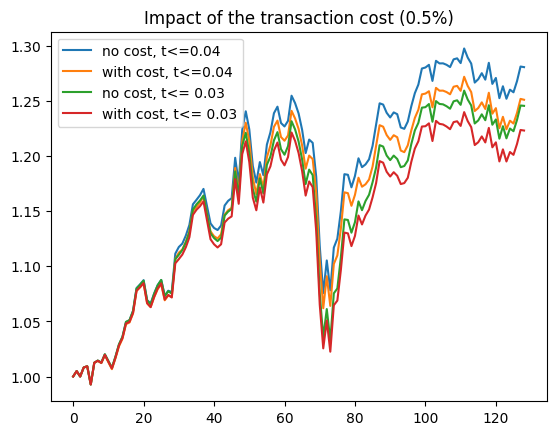

In [16]:
cost = 0.005
_,V_nc4 = realocation(returns,w_max=0.15,turnover=0.04)
plt.plot(V_nc4,label='no cost, t<=0.04')
_ ,V_tc4= realocation_transaction_cost(returns,c=cost)
plt.plot(V_tc4,label='with cost, t<=0.04')
_,V_nc3 = realocation(returns,w_max=0.15,turnover=0.03)
plt.plot(V_nc3,label='no cost, t<= 0.03')
_ ,V_tc3= realocation_transaction_cost(returns,turnover=0.03,c=cost)
plt.plot(V_tc3,label='with cost, t<= 0.03')

plt.title(f'Impact of the transaction cost ({100*cost}%)')
plt.legend()
plt.show()

In [17]:
evolutions_with_cost = [V_nc4,V_tc4,V_nc3,V_tc3]
comparison_with_cost = pd.DataFrame(columns=['return','std','SR','MDD'])

for k,v in enumerate(evolutions_with_cost) : 
    r =  (v[1:]-v[:-1])/v[:-1]
    mu =(1+np.mean(r))**252 - 1
    std = np.sqrt(252)*np.std(r)
    sr = (mu - r_f)/std
    mdd =  np.max((np.maximum.accumulate(v)-v)/np.maximum.accumulate(v))
    
    if k == 0 :
        comparison_with_cost.loc['No cost, t<=0.04'] = np.round(np.array([mu,std,sr,mdd]),3) 
    elif k==1 :
        comparison_with_cost.loc['With cost, t<=0.04'] = np.round(np.array([mu,std,sr,mdd]),3) 
    elif k==2 : 
        comparison_with_cost.loc['No cost, t<=0.03'] = np.round(np.array([mu,std,sr,mdd]),3) 
    else : 
        comparison_with_cost.loc['With cost, t<=0.03'] = np.round(np.array([mu,std,sr,mdd]),3) 

print(comparison_with_cost)

                    return    std     SR    MDD
No cost, t<=0.04     0.665  0.213  3.007  0.143
With cost, t<=0.04   0.590  0.213  2.656  0.144
No cost, t<=0.03     0.579  0.221  2.514  0.161
With cost, t<=0.03   0.524  0.221  2.264  0.163
